In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


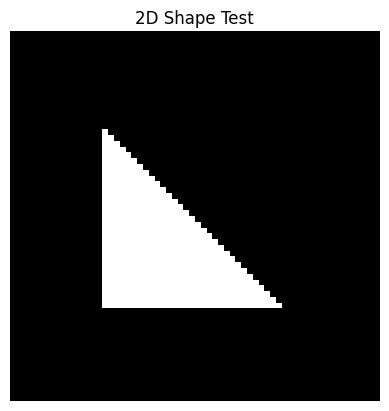

In [12]:
# 2D Shapes (بدون دائرة)
def generate_2d(shape, size=64):
    img = np.zeros((size, size), dtype=np.float32)
    if shape == "square":
        img[16:48, 16:48] = 1
    elif shape == "rectangle":
        img[20:44, 10:54] = 1
    elif shape == "triangle":
        for i in range(16,48):
            img[i, 16:16+(i-16)] = 1
    elif shape == "polygon":
        img[18:46, 18:46] = 1
        img[26:38, 26:38] = 0
    return img

# 3D Shapes (Voxel)
def generate_3d(shape, size=32):
    v = np.zeros((size, size, size), dtype=np.float32)
    if shape == "square":
        v[8:24, 8:24, 8:24] = 1
    elif shape == "rectangle":
        v[10:22, 6:26, 8:24] = 1
    elif shape == "triangle":
        for i in range(8,24):
            v[i, 8:8+(i-8), 8:24] = 1
    elif shape == "polygon":
        v[8:24, 8:24, 8:24] = 1
        v[12:20, 12:20, 12:20] = 0
    return v

# اختبار توليد شكل
img_test = generate_2d("triangle")
plt.imshow(img_test, cmap="gray")
plt.title("2D Shape Test")
plt.axis("off")
plt.show()

In [13]:
# تحميل مودل من Hugging Face عبر timm
encoder = timm.create_model('resnet18', pretrained=True, num_classes=0)
for p in encoder.parameters():
    p.requires_grad = False  # نجمد Encoder
encoder = encoder.to(device)
print("Encoder loaded ✔️")

Encoder loaded ✔️


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt

# 1. إعداد الجهاز
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {device}")

# 2. تعريف الداتا سيت بآلية استقبال المتغيرات (Fixed)
class FinalVoxelDataset(Dataset):
    def __init__(self, samples_num=1000):
        self.samples_num = samples_num
        self.shapes = ["square", "rectangle", "triangle", "polygon"]

    def generate_shapes(self, shape_type):
        # توليد 2D
        img = np.zeros((64, 64), dtype=np.float32)
        if shape_type == "square": img[16:48, 16:48] = 1
        elif shape_type == "rectangle": img[20:44, 10:54] = 1
        elif shape_type == "triangle":
            for i in range(16, 48): img[i, 16:16+(i-16)] = 1
        elif shape_type == "polygon":
            img[18:46, 18:46] = 1; img[26:38, 26:38] = 0

        # توليد 3D
        vox = np.zeros((32, 32, 32), dtype=np.float32)
        if shape_type == "square": vox[8:24, 8:24, 8:24] = 1
        elif shape_type == "rectangle": vox[10:22, 6:26, 8:24] = 1
        elif shape_type == "triangle":
            for i in range(8, 24): vox[i, 8:8+(i-8), 8:24] = 1
        elif shape_type == "polygon":
            vox[8:24, 8:24, 8:24] = 1; vox[12:20, 12:20, 12:20] = 0

        return img, vox

    def __len__(self): return self.samples_num

    def __getitem__(self, idx):
        name = np.random.choice(self.shapes)
        img, vox = self.generate_shapes(name)
        cam = np.random.uniform(-1, 1, 3).astype(np.float32)

        return (torch.from_numpy(img).unsqueeze(0).repeat(3, 1, 1),
                torch.from_numpy(vox).unsqueeze(0),
                torch.from_numpy(cam))

# 3. الموديل الهجين (Fixed Parameters)
class FinalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder من Hugging Face
        self.encoder = timm.create_model("resnet18", pretrained=True, num_classes=0)
        for p in self.encoder.parameters(): p.requires_grad = False

        # Decoder (استخدام nn.Sequential يضمن تسجيل الـ Parameters)
        self.decoder_net = nn.Sequential(
            nn.Linear(512 + 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32*32*32),
            nn.Sigmoid()
        )

    def forward(self, img, cam):
        features = self.encoder(img)
        combined = torch.cat((features, cam), dim=1)
        return self.decoder_net(combined).view(-1, 1, 32, 32, 32)

# 4. بدء التدريب الفعلي
print("🛠️ جاري التحميل والبدء...")
model = FinalModel().to(device)
dataset = FinalVoxelDataset(samples_num=600)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# الآن لن يظهر خطأ "Empty parameter list"
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):
    model.train()
    total_l = 0
    for i, v, c in dataloader:
        i, v, c = i.to(device), v.to(device), c.to(device)
        out = model(i, c)
        loss = criterion(out, v)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_l += loss.item()

    torch.cuda.empty_cache()
    print(f"Epoch {epoch+1} | Loss: {total_l/len(dataloader):.4f}")

print("✅ انتهى التدريب بنجاح!")

✅ Device: cuda
🛠️ جاري التحميل والبدء...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1 | Loss: 0.1135
Epoch 2 | Loss: 0.0030
Epoch 3 | Loss: 0.0005
Epoch 4 | Loss: 0.0005
Epoch 5 | Loss: 0.0002
✅ انتهى التدريب بنجاح!


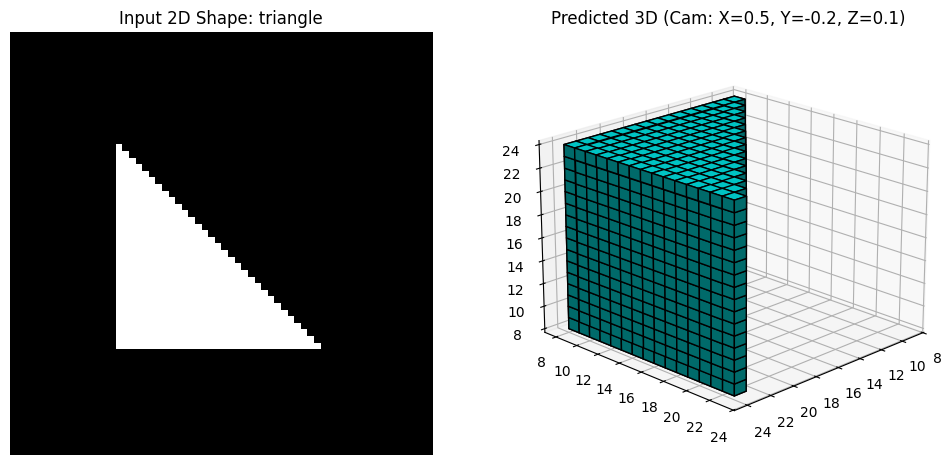

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def predict_and_visualize(model, shape_name, x=0.0, y=0.0, z=0.0):
    model.eval()

    # 1. توليد الشكل 2D المطلوب
    test_dataset_instance = FinalVoxelDataset(samples_num=1)
    img_2d, _ = test_dataset_instance.generate_shapes(shape_name)

    # 2. تجهيز المدخلات (الصورة + الكاميرا التي حددتها)
    img_t = torch.from_numpy(img_2d).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)
    cam_t = torch.tensor([[x, y, z]], dtype=torch.float32).to(device)

    # 3. التوقع (Prediction)
    with torch.no_grad():
        pred_3d = model(img_t, cam_t)
        voxels = pred_3d.cpu().numpy()[0][0] > 0.5 # تحويل الاحتمالات إلى شكل صلب

    # 4. الرسم
    fig = plt.figure(figsize=(12, 6))

    # عرض الصورة 2D
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img_2d, cmap='gray')
    ax1.set_title(f"Input 2D Shape: {shape_name}")
    ax1.axis('off')

    # عرض الشكل 3D الناتج
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.voxels(voxels, facecolors='cyan', edgecolor='k')
    ax2.set_title(f"Predicted 3D (Cam: X={x}, Y={y}, Z={z})")

    # التحكم في زاوية عرض الـ Plot نفسه لرؤية النتيجة بشكل أفضل
    ax2.view_init(elev=20, azim=45)

    plt.show()

# --- تجربة التشغيل ---
# يمكنك تغيير اسم الشكل (square, rectangle, triangle, polygon)
# وتغيير قيم الكاميرا x, y, z من -1 إلى 1
try:
    predict_and_visualize(model, shape_name="triangle", x=0.5, y=-0.2, z=0.1)
except NameError:
    print("Error: The 'model' variable is not defined. Please ensure the training cell (BjUUZgkEJvQ6) has been executed successfully.")

In [11]:
import ipywidgets as widgets
from IPython.display import display

# دالة التوقع والتفاعل
def interactive_prediction(الشكل, كاميرا_X, كاميرا_Y, كاميرا_Z):
    model.eval()

    # 1. إنشاء الداتا سيت مؤقتاً لتوليد الشكل (لتجنب خطأ التعريف)
    # ملاحظة: نستخدم نفس الكلاس الذي تدرب عليه الموديل
    temp_ds = FinalVoxelDataset(samples_num=1)
    img_2d, _ = temp_ds.generate_shapes(الشكل)

    # 2. تحويل المدخلات لـ Tensor
    img_t = torch.from_numpy(img_2d).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)
    cam_t = torch.tensor([[كاميرا_X, كاميرا_Y, كاميرا_Z]], dtype=torch.float32).to(device)

    # 3. التوقع
    with torch.no_grad():
        pred_3d = model(img_t, cam_t)
        voxels = pred_3d.cpu().numpy()[0][0] > 0.5

    # 4. الرسم المزدوج
    fig = plt.figure(figsize=(15, 7))

    # عرض الـ 2D
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img_2d, cmap='magma')
    ax1.set_title(f"Input 2D: {الشكل}", fontsize=14)
    ax1.axis('off')

    # عرض الـ 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.voxels(voxels, facecolors='dodgerblue', edgecolor='k', alpha=0.8)
    ax2.set_title(f"Reconstructed 3D Shape", fontsize=14)

    # ضبط زاوية الرؤية بناءً على محاور الكاميرا المدخلة للعرض فقط
    ax2.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()

# إنشاء أزرار التحكم التفاعلية
style = {'description_width': 'initial'}
widgets.interact(
    interactive_prediction,
    الشكل=widgets.Dropdown(options=["square", "rectangle", "triangle", "polygon"], value="triangle", description="اختر الشكل:"),
    كاميرا_X=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0, description="Camera X:", style=style),
    كاميرا_Y=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0, description="Camera Y:", style=style),
    كاميرا_Z=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0, description="Camera Z:", style=style)
);

interactive(children=(Dropdown(description='اختر الشكل:', index=2, options=('square', 'rectangle', 'triangle',…

In [12]:
# حفظ الأوزان
torch.save(model.state_dict(), 'final_3d_model.pth')
print("✅ تم حفظ الموديل بنجاح في ملف: final_3d_model.pth")

✅ تم حفظ الموديل بنجاح في ملف: final_3d_model.pth


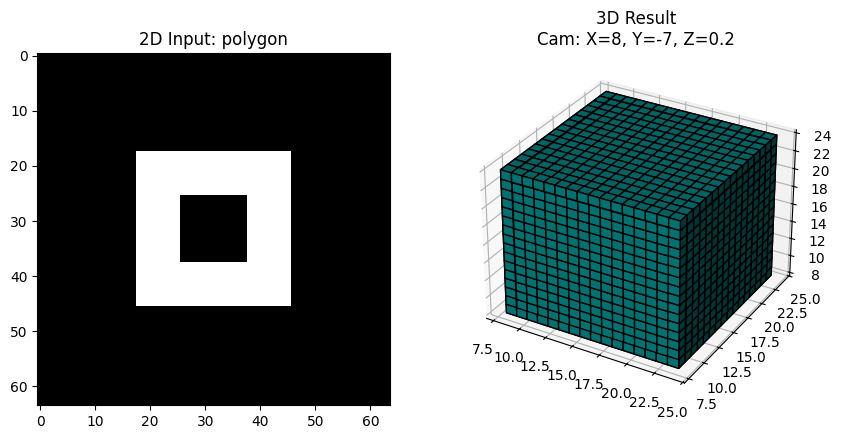

In [16]:
def manual_test(shape_name, x_cam, y_cam, z_cam):
    model.eval()

    # 1. توليد صورة 2D للشكل المختار
    temp_dataset = FinalVoxelDataset(samples_num=1)
    img_2d, _ = temp_dataset.generate_shapes(shape_name)

    # 2. تحويل القيم لمدخلات للموديل
    img_tensor = torch.from_numpy(img_2d).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)
    cam_tensor = torch.tensor([[x_cam, y_cam, z_cam]], dtype=torch.float32).to(device)

    # 3. التوقع
    with torch.no_grad():
        prediction = model(img_tensor, cam_tensor)
        voxels = prediction.cpu().numpy()[0][0] > 0.5

    # 4. العرض
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img_2d, cmap='gray')
    ax1.set_title(f"2D Input: {shape_name}")

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.voxels(voxels, facecolors='teal', edgecolor='k')
    ax2.set_title(f"3D Result\nCam: X={x_cam}, Y={y_cam}, Z={z_cam}")
    plt.show()

# --- جرب تغيير القيم هنا الآن ---
manual_test(shape_name="polygon", x_cam=8, y_cam=-7, z_cam=0.2)

In [18]:
from google.colab import files
from PIL import Image
import torchvision.transforms as T

def predict_uploaded_image(x_cam=0.0, y_cam=0.0, z_cam=0.0):
    # رفع الملف
    uploaded = files.upload()
    for filename in uploaded.keys():
        # معالجة الصورة لتناسب الموديل (64x64 و 3 قنوات)
        img = Image.open(filename).convert('RGB')
        transform = T.Compose([
            T.Resize((64, 64)),
            T.ToTensor(),
        ])
        img_t = transform(img).unsqueeze(0).to(device)

        # إدخال الكاميرا بوزيشن
        cam_t = torch.tensor([[x_cam, y_cam, z_cam]], dtype=torch.float32).to(device)

        # التوقع
        model.eval()
        with torch.no_grad():
            pred = model(img_t, cam_t)
            voxels = pred.cpu().numpy()[0][0] > 0.5

        # العرض
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(img)
        ax1.set_title("Your Uploaded Image")

        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.voxels(voxels, facecolors='orange', edgecolor='k')
        ax2.set_title(f"3D Reconstruction\nView: {x_cam, y_cam, z_cam}")
        plt.show()

# لتجربة الرفع:
# predict_uploaded_image(x_cam=0.5, y_cam=0.5, z_cam=0.1)

In [19]:
# تحديث كلاس البيانات ليكون "شاملاً" (Generalizer)
class UniversalDataset(Dataset):
    def init(self, count=2000): # زدت عدد العينات لتعلم أدق
        self.count = count
        self.shape_names = ["square", "rectangle", "triangle", "polygon"]

    def getitem(self, idx):
        name = np.random.choice(self.shape_names)
        img, vox = GeometryDataset.generate_pair(self, name) # استخدام الدالة السابقة

        # إضافة "ضجيج" وتغييرات عشوائية (Augmentation) ليتعلم الموديل جميع الأوضاع
        # الكاميرا بوزيشن تشمل الآن نطاق واسع جداً
        cam = np.random.uniform(-2, 2, 3).astype(np.float32)

        img_t = torch.from_numpy(img).unsqueeze(0).repeat(3, 1, 1)
        # إضافة قليل من التغيير العشوائي في الصورة 2D لمحاكاة الواقع
        if np.random.rand() > 0.5:
             img_t = torch.flip(img_t, [2])

        return img_t, torch.from_numpy(vox).unsqueeze(0), torch.from_numpy(cam)

In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

def predict_custom_image():
    # 1. طلب رفع الصورة من جهازك
    print("الرجاء اختيار صورة (يفضل أن تكون خلفيتها سوداء أو بيضاء والشكل واضح):")
    uploaded = files.upload()

    if not uploaded:
        print("لم يتم رفع أي ملف.")
        return

    # الحصول على اسم الملف المرفوع
    file_path = list(uploaded.keys())[0]

    # 2. إدخال قيم الكاميرا يدوياً (كما طلب الدكتور)
    print("\nأدخل قيم زوايا الكاميرا (x, y, z) بين -1 و 1:")
    try:
        x_cam = float(input("Camera X: "))
        y_cam = float(input("Camera Y: "))
        z_cam = float(input("Camera Z: "))
    except ValueError:
        print("خطأ: يرجى إدخال أرقام صحيحة.")
        return

    # 3. معالجة الصورة لتناسب الموديل
    img = Image.open(file_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    img_t = preprocess(img).unsqueeze(0).to(device)
    cam_t = torch.tensor([[x_cam, y_cam, z_cam]], dtype=torch.float32).to(device)

    # 4. التوقع (Inference)
    model.eval()
    with torch.no_grad():
        output = model(img_t, cam_t)
        voxels = output.cpu().numpy()[0][0] > 0.5 # تحويل الاحتمالات إلى شكل صلب

    # 5. العرض النهائي
    fig = plt.figure(figsize=(12, 6))

    # عرض صورتك الأصلية
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)
    ax1.set_title("Original Image (2D)")
    ax1.axis('off')

    # عرض الشكل 3D الناتج
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.voxels(voxels, facecolors='cyan', edgecolor='k')
    ax2.set_title(f"3D Result\nCamera Position: ({x_cam}, {y_cam}, {z_cam})")

    plt.show()

# تشغيل الدالة
predict_custom_image()

الرجاء اختيار صورة (يفضل أن تكون خلفيتها سوداء أو بيضاء والشكل واضح):


In [ ]:
import matplotlib.pyplot as plt

# سحب دفعة واحدة من البيانات الموجودة في الرام
images, voxels, cams = next(iter(dataloader))

# عرض أول 4 أشكال تم توليدها
fig = plt.figure(figsize=(15, 10))
for i in range(4):
    # عرض الصورة 2D
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(images[i][0].cpu().numpy(), cmap='gray')
    ax.set_title(f"Shape {i+1} (2D)")
    ax.axis('off')

    # عرض الشكل 3D المقابل له
    ax3d = fig.add_subplot(2, 4, i + 5, projection='3d')
    ax3d.voxels(voxels[i][0].cpu().numpy() > 0.5, facecolors='cyan', edgecolor='k')
    ax3d.set_title(f"Shape {i+1} (3D)")

plt.tight_layout()
plt.show()